In [1]:
### SETUP ###
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import PIL
import PIL.Image
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow_hub as hub


dirname = '/kaggle/input/celebrity-face-image-dataset/Celebrity Faces Dataset/'

class_count = 17
ds_size = 1800

batch_size = 32
img_height = 224
img_width = 224

## Reference: https://www.tensorflow.org/tutorials/images/classification
## Use 80% of the images for training and 20% for validation.
## Below is 80% of Training
train_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="training",
  seed=123,
  image_size=(img_height, img_width))

## Below is the 20% for Validation
test_ds = tf.keras.utils.image_dataset_from_directory(
  dirname,
  validation_split=0.20,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width))

## Creating test and validation datasets (10%-10%)
## Reference; https://stackoverflow.com/questions/48213766/split-a-dataset-created-by-tensorflow-dataset-api-in-to-train-and-test#:~:text=A%20robust%20way%20to%20split,by%20filtering%20by%20the%20bucket.
val_size = int(0.1 * ds_size)
test_size = int(0.1 * ds_size)

validation_ds = test_ds.take(val_size)
testing_ds = test_ds.skip(test_size)
print(f"testing_ds: {testing_ds}")
print(f"validation: {validation_ds}")

## Class Names
class_names = train_ds.class_names
print(test_ds.class_names)

## Do data augmentation to training and validation set only
## Reference: https://pyimagesearch.com/2021/06/28/data-augmentation-with-tf-data-and-tensorflow/



Found 1800 files belonging to 17 classes.
Using 1440 files for training.


2022-11-26 03:32:59.656989: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 03:32:59.658300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 03:32:59.686448: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 03:32:59.689672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 03:32:59.690837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 1800 files belonging to 17 classes.
Using 360 files for validation.
testing_ds: <SkipDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
validation: <TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


2022-11-26 03:33:15.600211: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


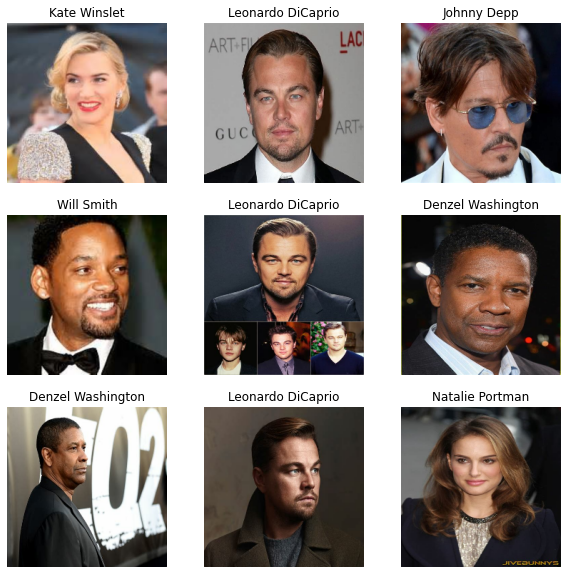

In [2]:
## Visualize the Data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [3]:
# Batch size refers to the # of training examples utilized 
# in one iteration.
# I can call .numpy() on the image_batch and labels_batch tensors 
# to convert them to a numpy.ndarray.

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2022-11-26 03:33:25.947183: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [28]:
from keras.applications.vgg19 import VGG19
vgg19_model = VGG19(weights='imagenet',include_top=False)


In [29]:
x=vgg19_model.output
from keras.layers import Dense,GlobalAveragePooling2D

x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(class_count, activation='softmax')(x) #final layer with softmax activation


In [30]:
from keras.models import Model
newModel=Model(inputs=vgg19_model.input,outputs=preds)

In [31]:
import datetime
# Train the Model
# Train the model for 10 epochs with the Keras Model.fit method
newModel.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0075, momentum=0.0),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=[tf.keras.metrics.sparse_categorical_accuracy]),

(None,)

In [32]:
NUM_EPOCHS = 20

history = newModel.fit(train_ds,
                    validation_data=validation_ds,
                    epochs=NUM_EPOCHS)

Epoch 1/20
45/45 [==============================] - 25s 536ms/step - loss: 2.7392 - sparse_categorical_accuracy: 0.1333 - val_loss: 2.4800 - val_sparse_categorical_accuracy: 0.1667
Epoch 2/20
45/45 [==============================] - 24s 541ms/step - loss: 2.3125 - sparse_categorical_accuracy: 0.2361 - val_loss: 2.3863 - val_sparse_categorical_accuracy: 0.2028
Epoch 3/20
45/45 [==============================] - 24s 538ms/step - loss: 1.9617 - sparse_categorical_accuracy: 0.3750 - val_loss: 1.7713 - val_sparse_categorical_accuracy: 0.3750
Epoch 4/20
45/45 [==============================] - 24s 530ms/step - loss: 1.6463 - sparse_categorical_accuracy: 0.4569 - val_loss: 1.9260 - val_sparse_categorical_accuracy: 0.3000
Epoch 5/20
45/45 [==============================] - 24s 542ms/step - loss: 1.2831 - sparse_categorical_accuracy: 0.5764 - val_loss: 1.4139 - val_sparse_categorical_accuracy: 0.5222
Epoch 6/20
45/45 [==============================] - 24s 533ms/step - loss: 1.1288 - sparse_cate

In [33]:
newModel.save("./michael_model.h5", save_format = 'h5')

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Data Augmentation
# Because our model is overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)